## Ex3 - Autoencoders

In [1]:
%matplotlib inline

import helper
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Consts

In [2]:
CIFAR_10_DATASET_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
CIFAR_10_DATASET_FOLDER_PATH = 'cifar-10-batches-py'
TAR_GZ_PATH = 'cifar-10-python.tar.gz'
SAVE_MODEL_PATH = './model'

NOISE_FACTOR = 5
N_BATCHES = 5

### Hyperparameters

In [3]:
epochs = 100
batch_size = 2000
learning_rate = 0.001
show_images_every_n_epochs = 5
do_preprocess = False
load_model = False

### Prepare the dataset

In [4]:
helper.download_dataset(CIFAR_10_DATASET_URL, CIFAR_10_DATASET_FOLDER_PATH, TAR_GZ_PATH) 
if do_preprocess:
    helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, N_BATCHES)

Cifar-10 dataset found


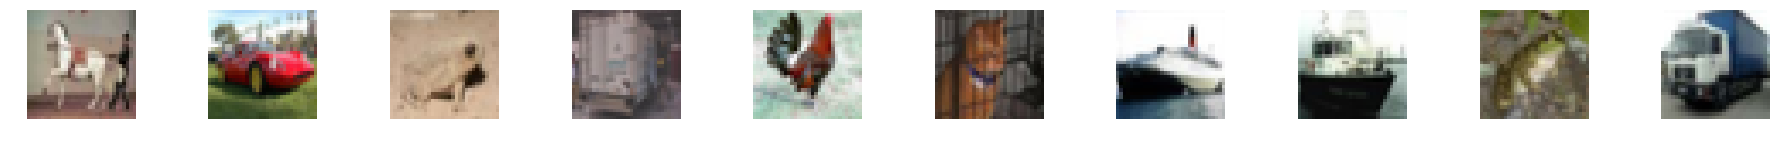

In [5]:
features, _ = helper.load_cfar10_batch(CIFAR_10_DATASET_FOLDER_PATH, random.randint(1, N_BATCHES))
valid_features, valid_noisy, _ = helper.load_preprocess_validation()[:10]
test_features, test_noisy, _ = helper.load_preprocess_testing()

plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(features[i + random.randint(0, len(features) - 10)])

### Build the network

In [6]:
inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

In [7]:
def unpool(value, name='unpool'):
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, tf.zeros_like(out)], i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [8]:
encoder_layer1 = tf.layers.conv2d(inputs_, 12, [5, 5], strides=(1, 1), padding="SAME")
pool_encoder_layer1 = tf.layers.max_pooling2d(encoder_layer1, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder_layer2 = tf.layers.conv2d(pool_encoder_layer1, 48, [5, 5], strides=(1, 1), padding="SAME")
pool_encoder_layer2 = tf.layers.max_pooling2d(encoder_layer2, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder_layer3 = tf.layers.conv2d(pool_encoder_layer2, 192, [5, 5], strides=(4, 4), padding="SAME")

decoder_layer1 = tf.layers.conv2d_transpose(encoder_layer3, 192, [5, 5], strides=(4, 4), padding="SAME")
unpool_decoder_layer2 = unpool(decoder_layer1)
decoder_layer2 = tf.layers.conv2d_transpose(unpool_decoder_layer2, 48, [5, 5], strides=(1, 1), padding="SAME")
unpool_decoder_layer3 = unpool(decoder_layer2)
decoder_layer3 = tf.layers.conv2d_transpose(unpool_decoder_layer3, 3, [5, 5], strides=(1, 1), padding="SAME")

y_pred = tf.identity(decoder_layer3, name='decoded')

cost = tf.reduce_mean(tf.abs(y_pred - targets_))
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Train the network

In [9]:
sess = tf.Session()

Training...
('Epoch: 1/100...', 'Training loss: 0.1760')
('Epoch: 2/100...', 'Training loss: 0.1359')
('Epoch: 3/100...', 'Training loss: 0.1128')
('Epoch: 4/100...', 'Training loss: 0.0978')
('Epoch: 5/100...', 'Training loss: 0.0918')
('Epoch: 6/100...', 'Training loss: 0.0886')
('Epoch: 7/100...', 'Training loss: 0.0838')
('Epoch: 8/100...', 'Training loss: 0.0808')
('Epoch: 9/100...', 'Training loss: 0.0797')
('Epoch: 10/100...', 'Training loss: 0.0766')
('Epoch: 11/100...', 'Training loss: 0.0744')
('Epoch: 12/100...', 'Training loss: 0.0737')
('Epoch: 13/100...', 'Training loss: 0.0730')
('Epoch: 14/100...', 'Training loss: 0.0715')
('Epoch: 15/100...', 'Training loss: 0.0715')
('Epoch: 16/100...', 'Training loss: 0.0684')
('Epoch: 17/100...', 'Training loss: 0.0713')
('Epoch: 18/100...', 'Training loss: 0.0671')
('Epoch: 19/100...', 'Training loss: 0.0669')
('Epoch: 20/100...', 'Training loss: 0.0682')
('Epoch: 21/100...', 'Training loss: 0.0654')
('Epoch: 22/100...', 'Training 

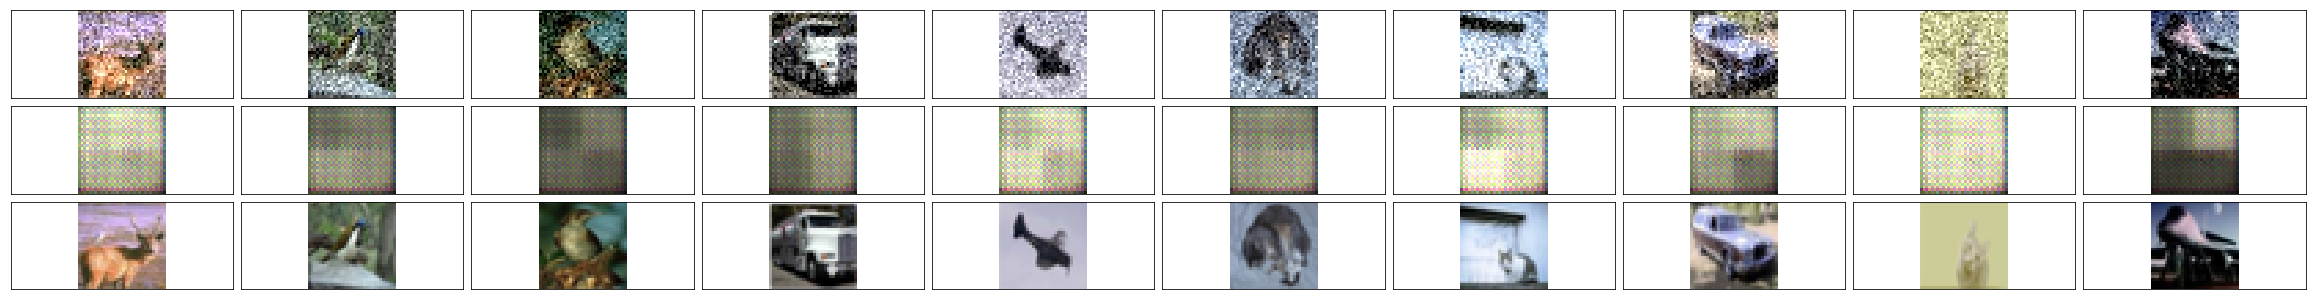

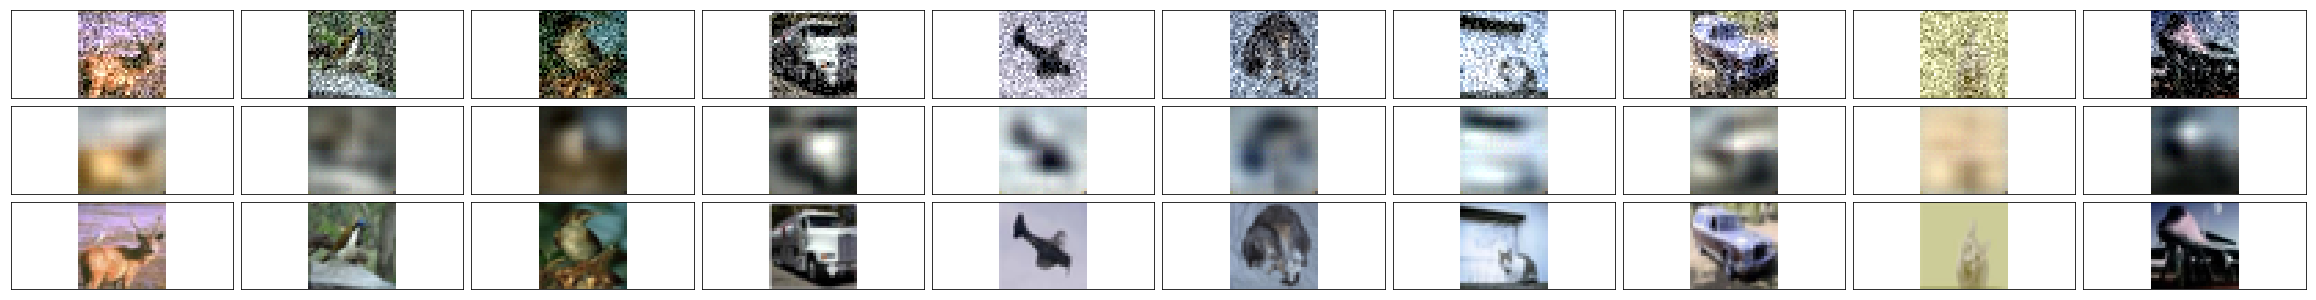

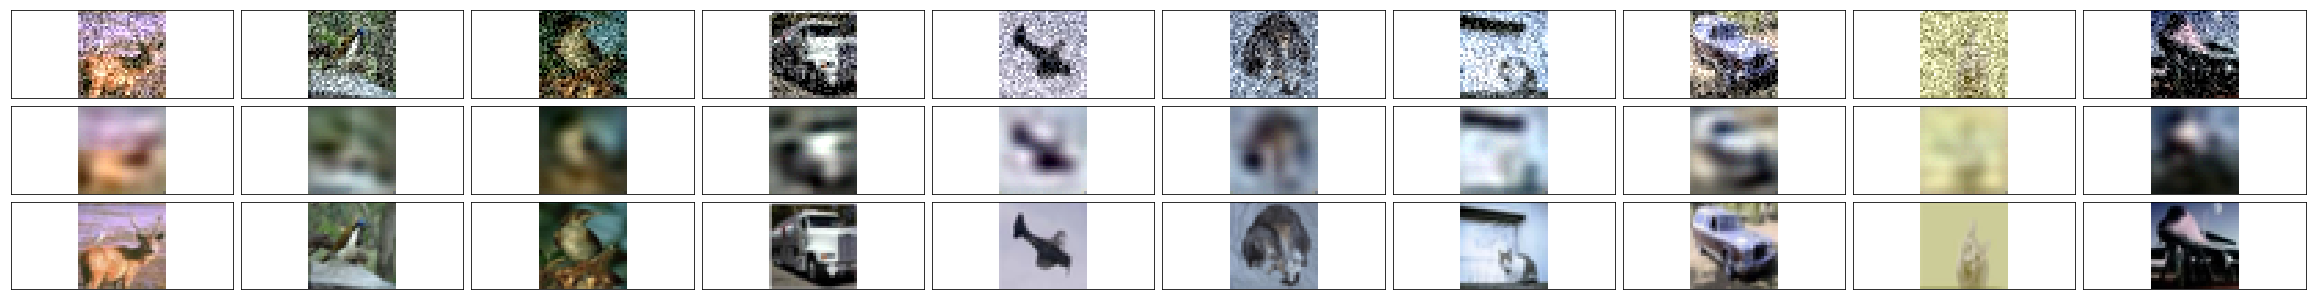

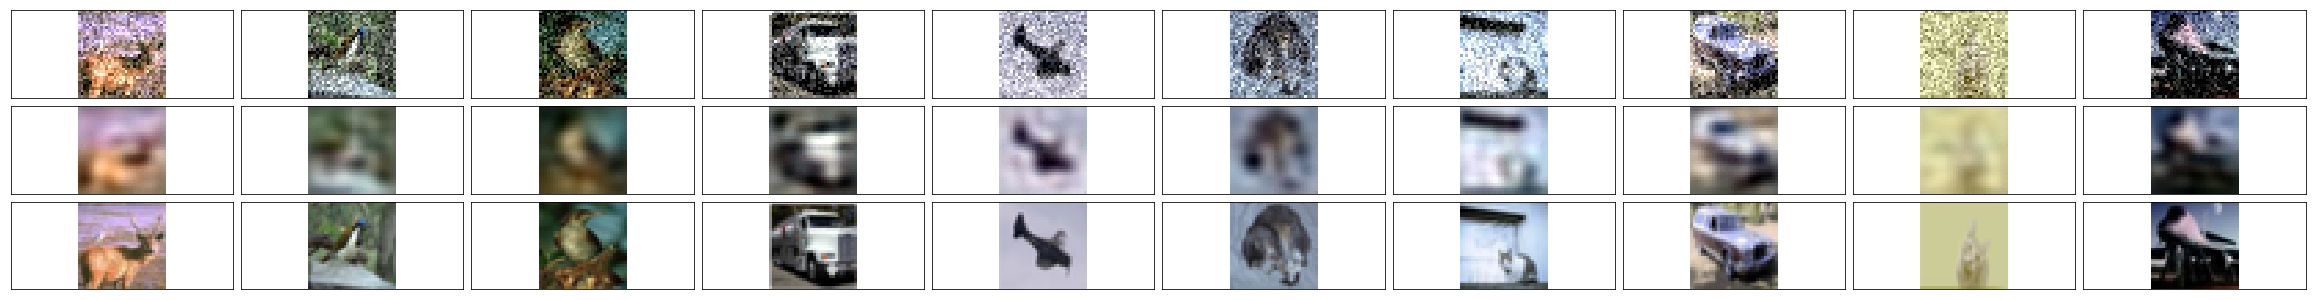

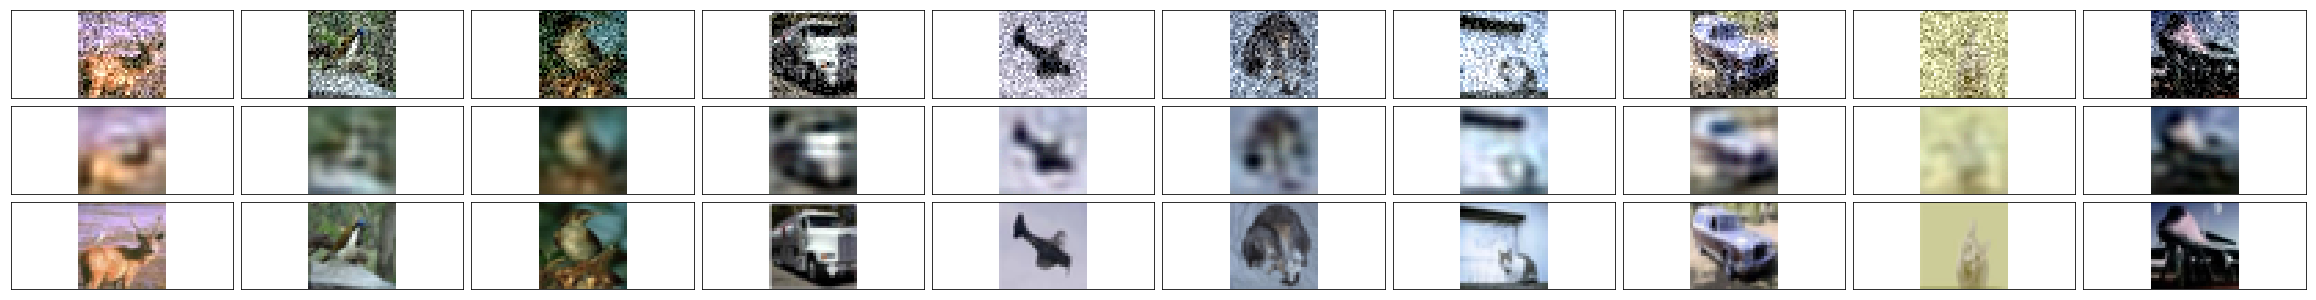

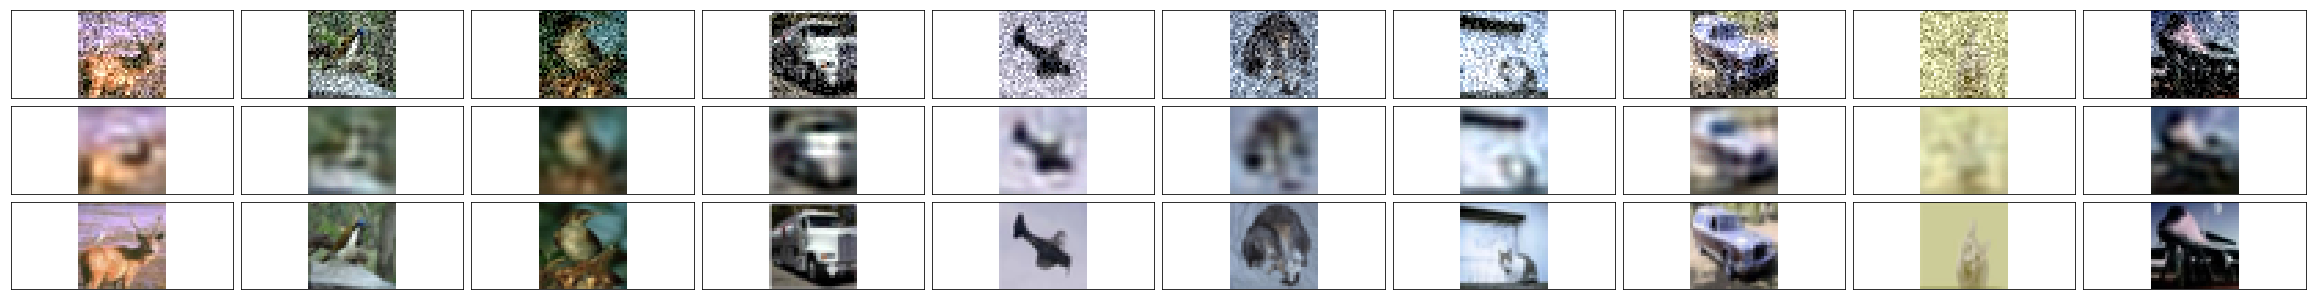

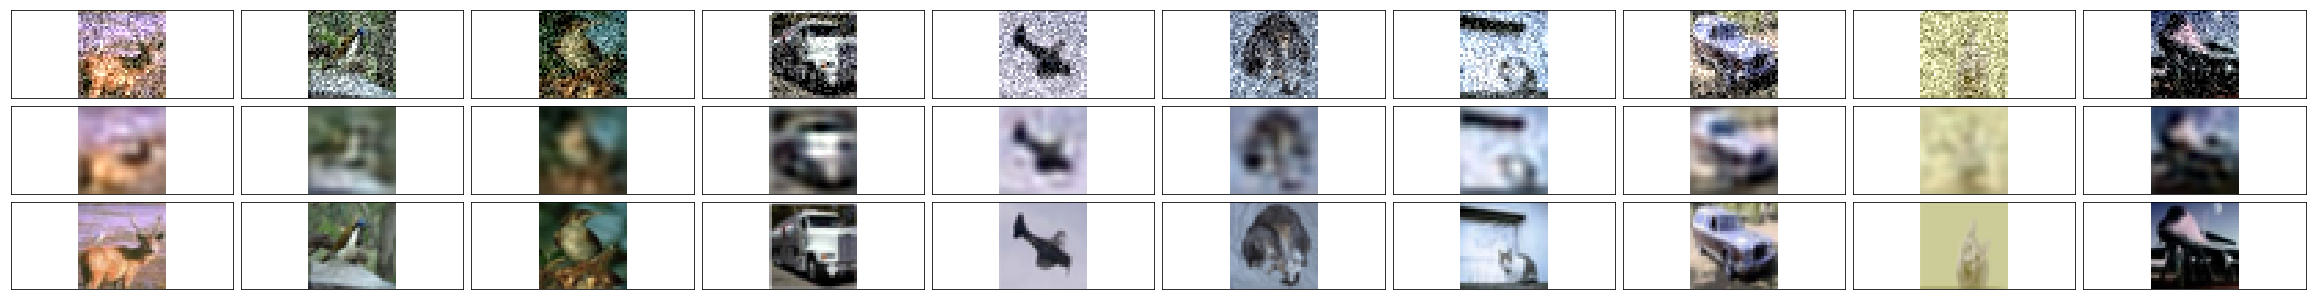

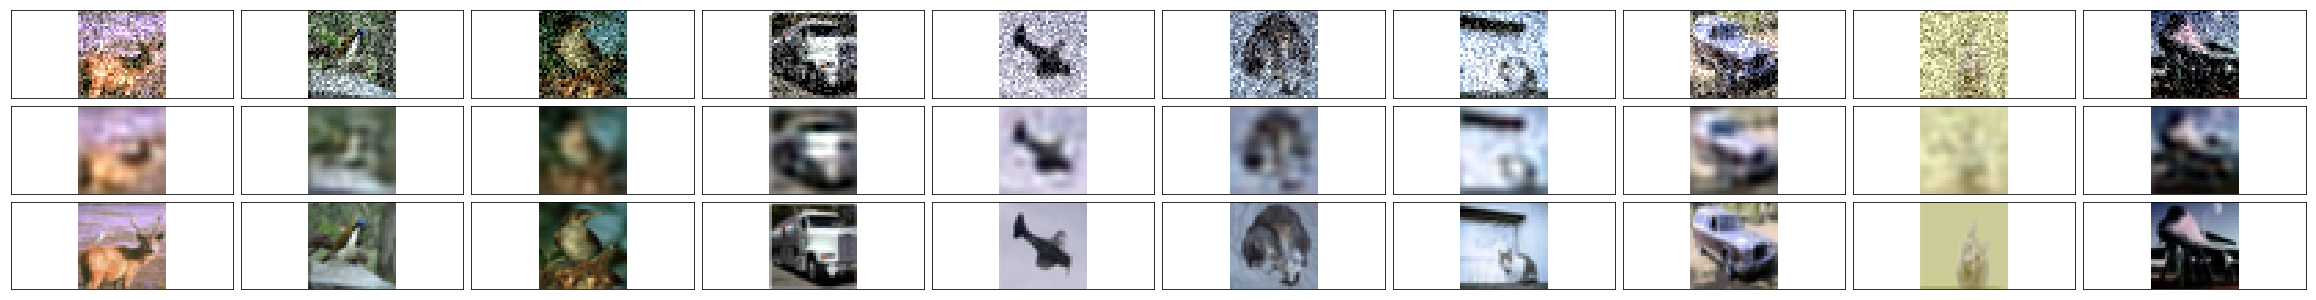

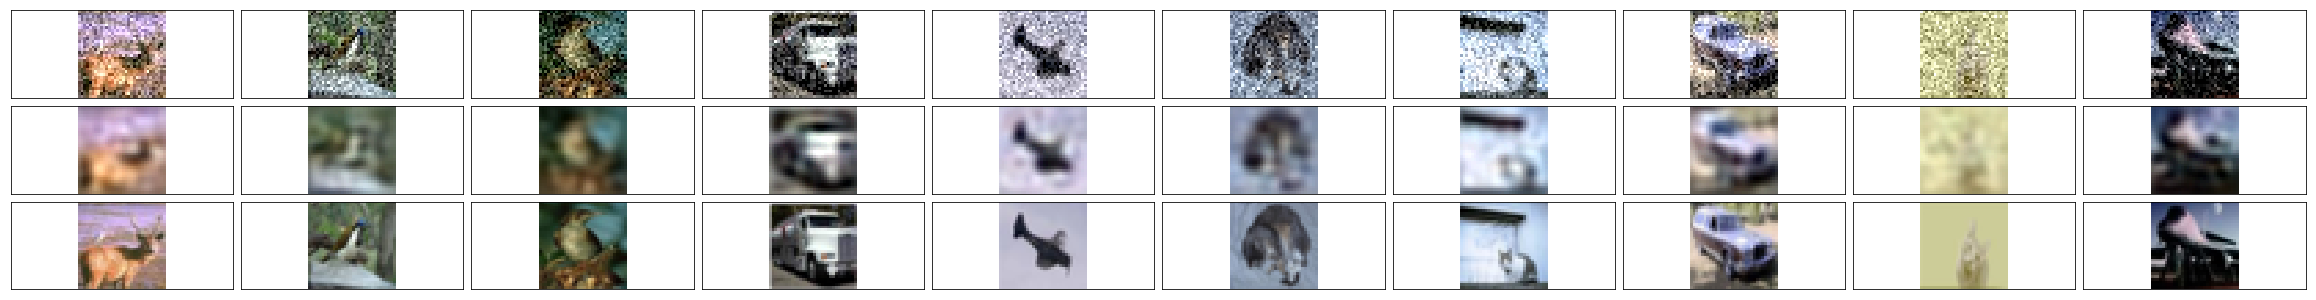

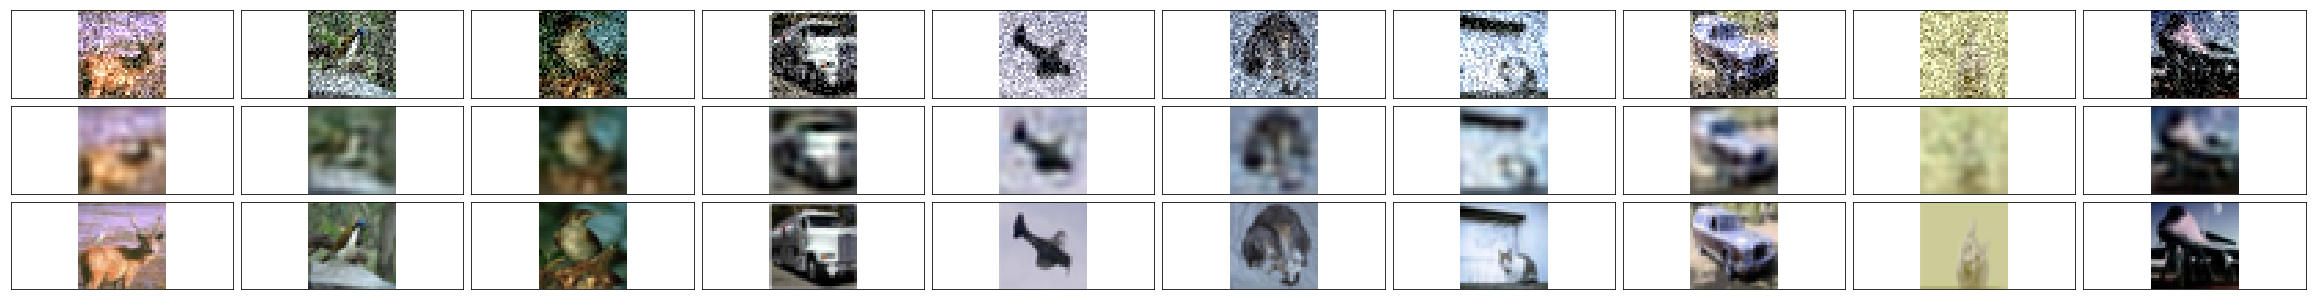

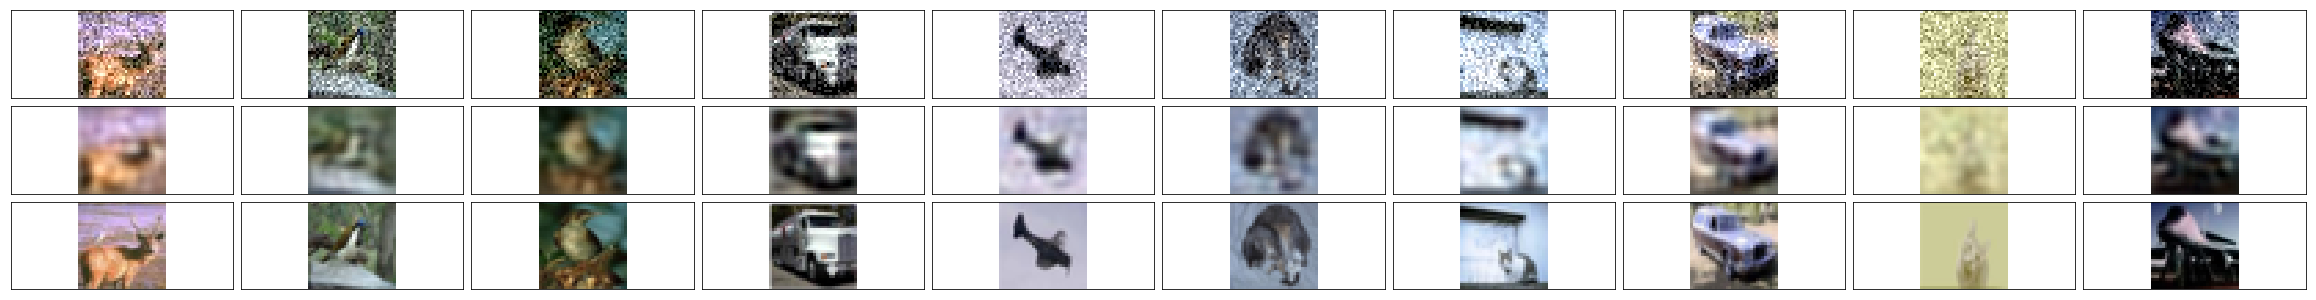

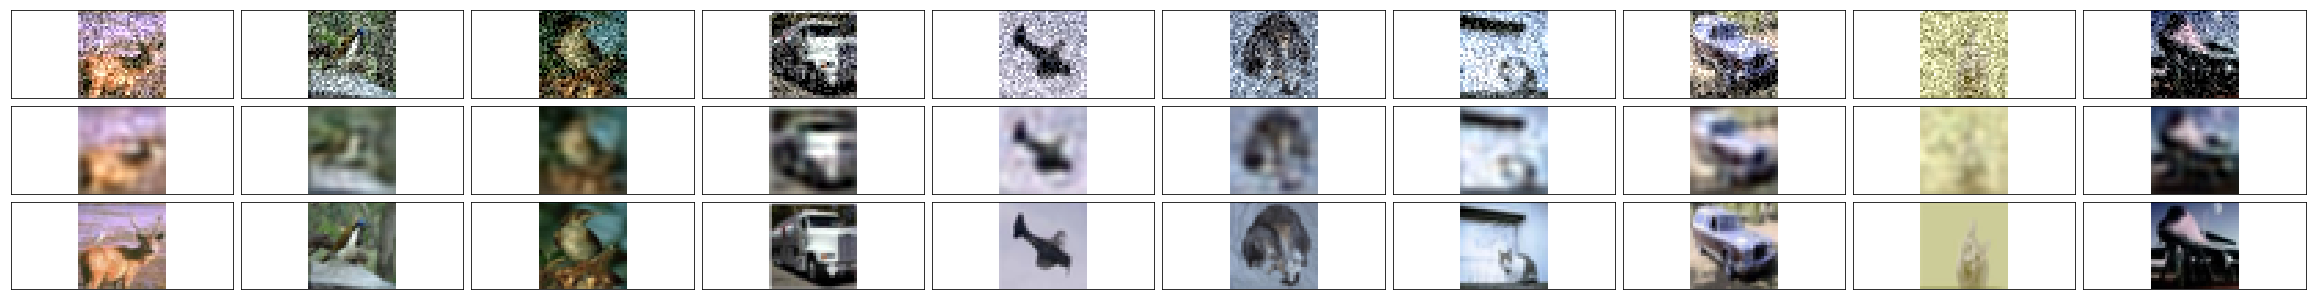

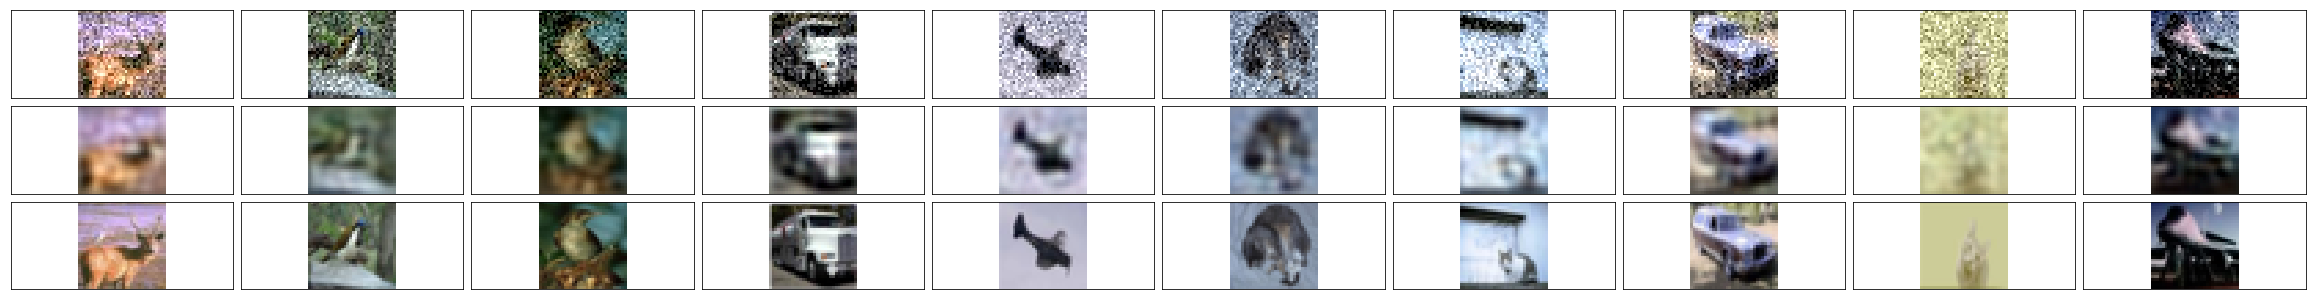

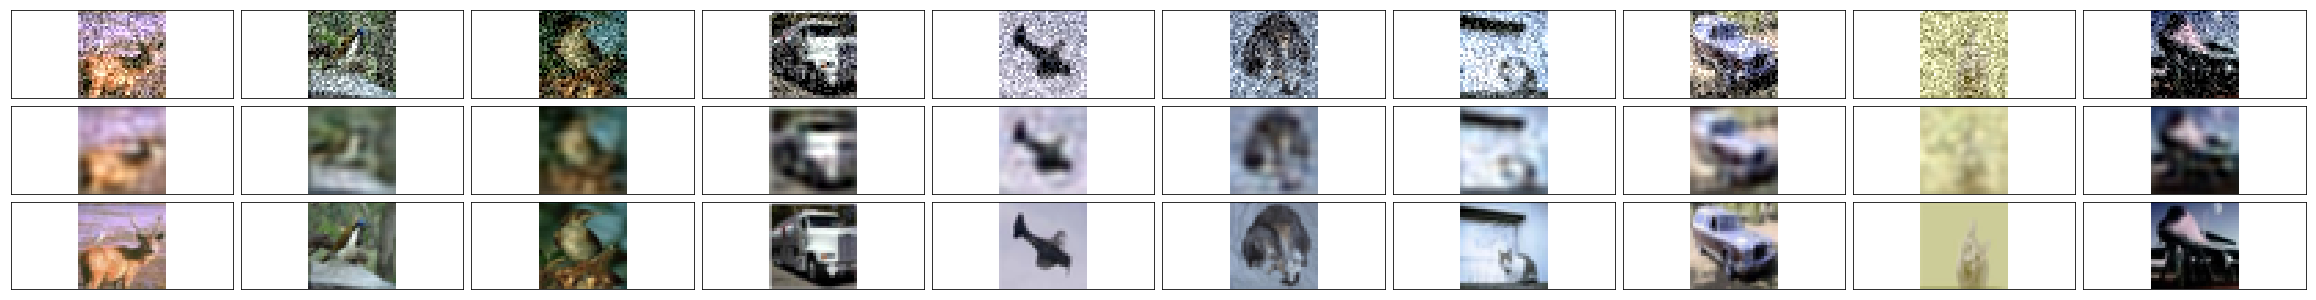

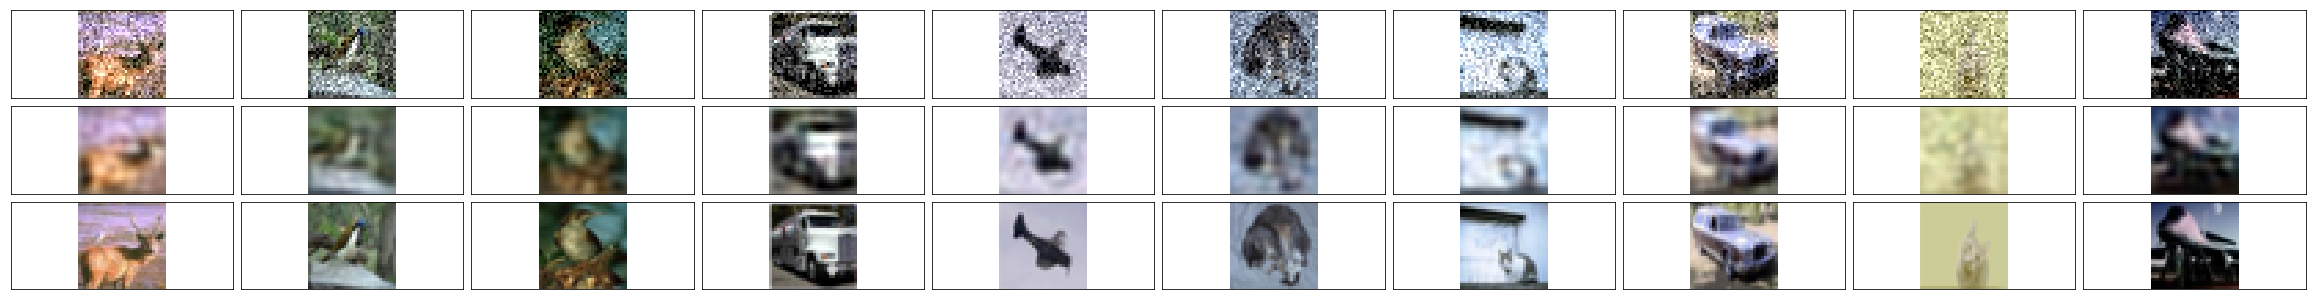

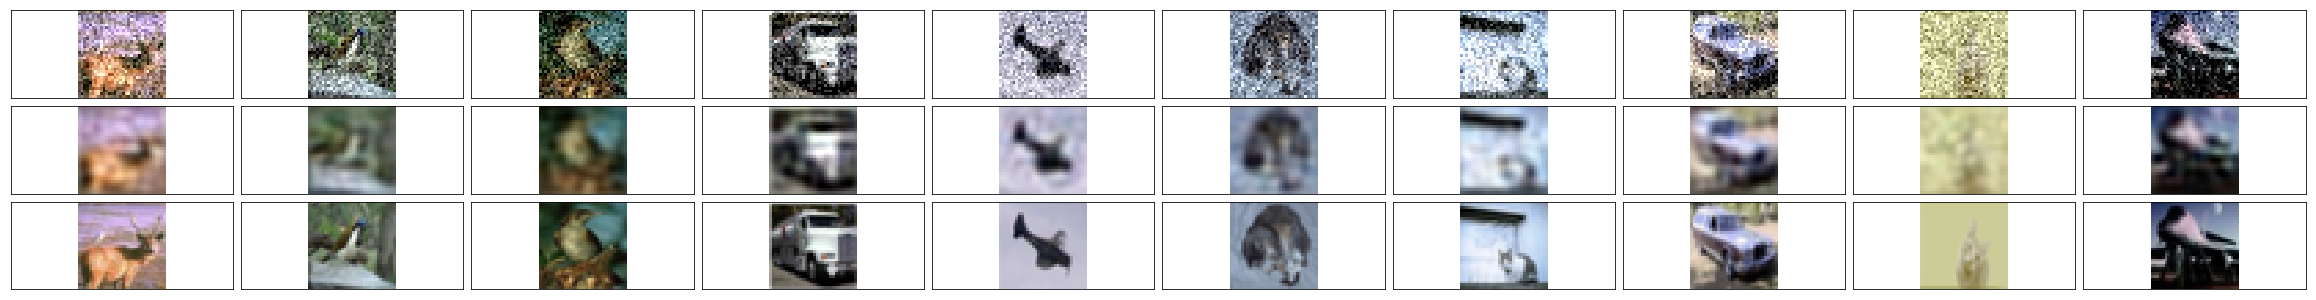

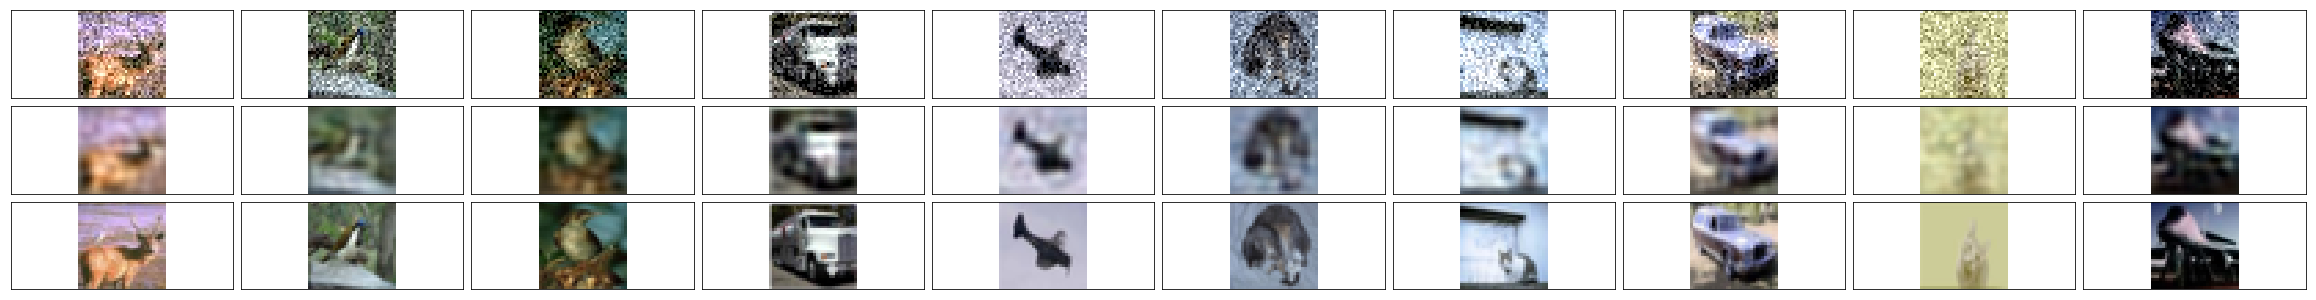

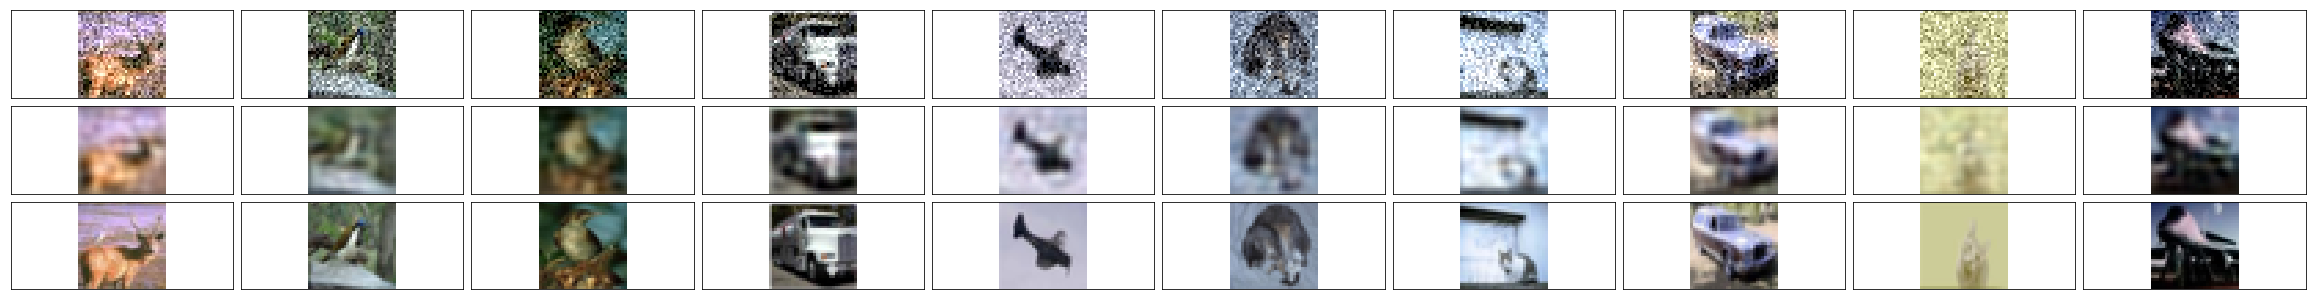

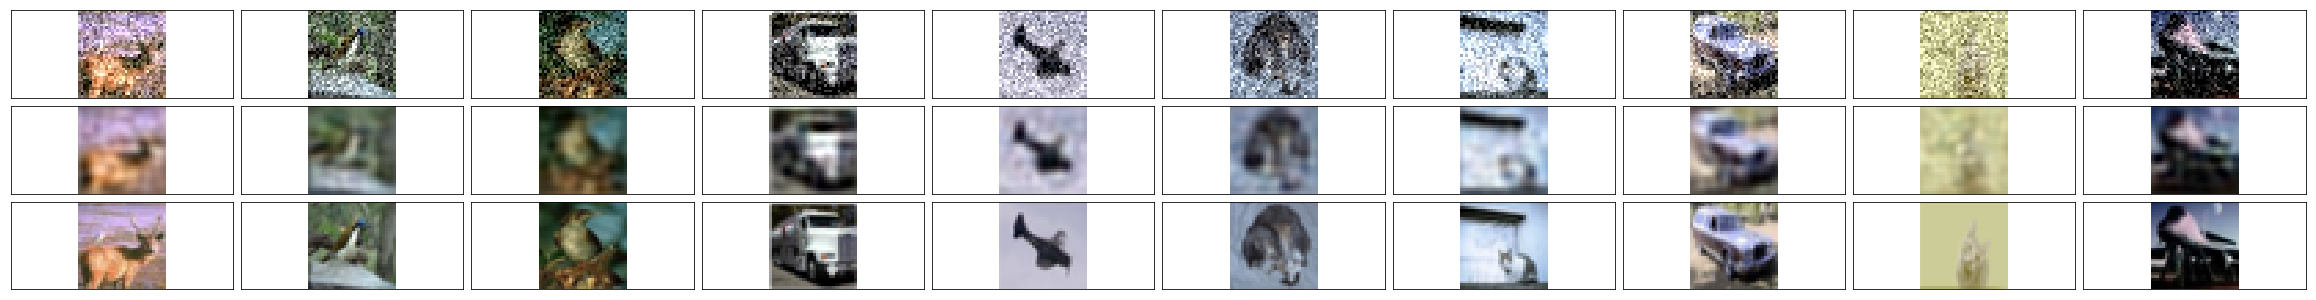

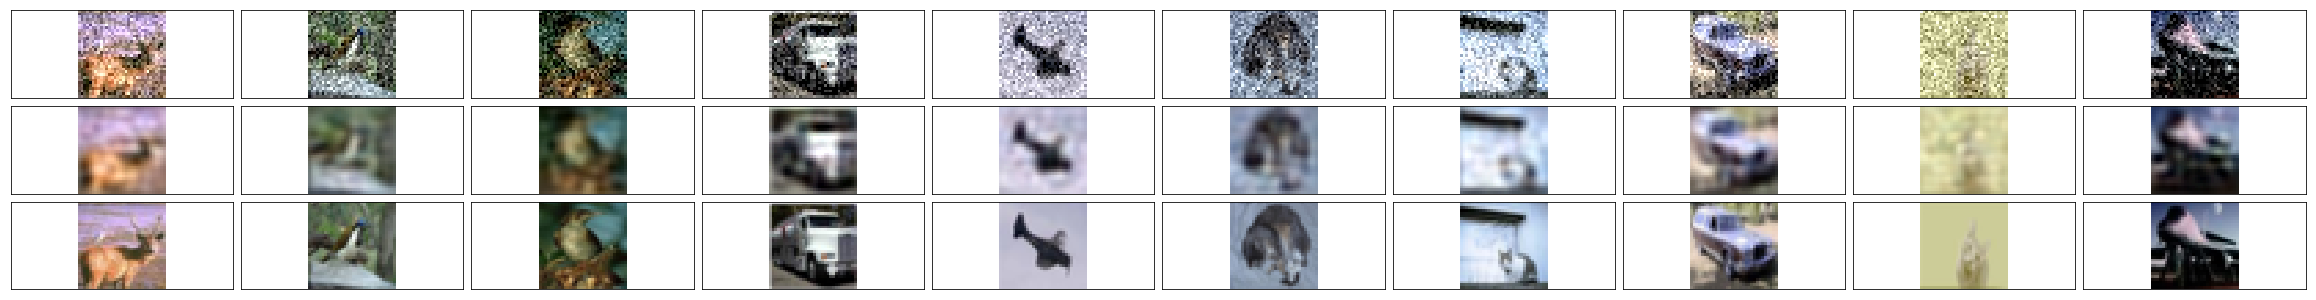

In [10]:
print('Training...')
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, N_BATCHES + 1):
        for features, noisy_features, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_features, targets_: features})
            
    print("Epoch: {}/{}...".format(e + 1, epochs), "Training loss: {:.4f}".format(batch_cost))
    if e % show_images_every_n_epochs == 0:
        reconstructed = sess.run(y_pred, feed_dict={inputs_: valid_noisy[:10].reshape((10, 32, 32, 3))})
        helper.show_images(valid_features, valid_noisy, np.clip(reconstructed, 0, 1))
        
saver = tf.train.Saver()
save_path = saver.save(sess, SAVE_MODEL_PATH)

### Test the network

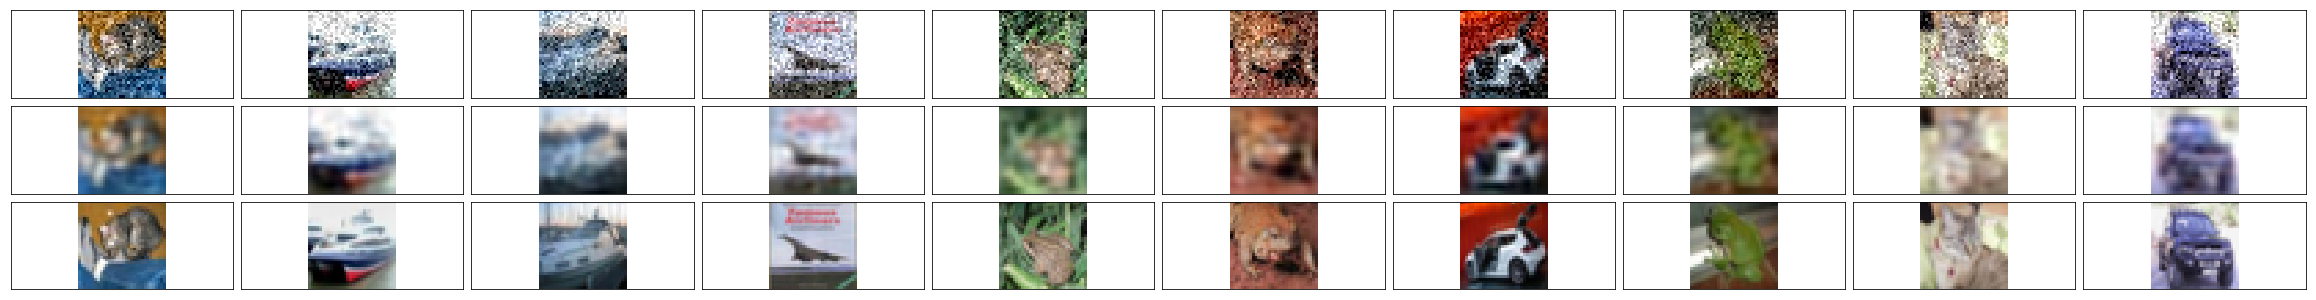

In [11]:
test_features = test_features[:10]
test_noisy = test_noisy[:10]

reconstructed = sess.run(y_pred, feed_dict={inputs_: test_noisy.reshape((10, 32, 32, 3))})

helper.show_images(test_features, test_noisy, np.clip(reconstructed, 0, 1))